In [18]:
import cPickle
from conf_analysis import pupil, behavior, patsy_transforms as pt
from pylab import *
import seaborn as sns

%load_ext autoreload
%autoreload 2
%matplotlib inline
sns.set_style('ticks')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
data = behavior.load_data()

In [20]:
# Fix a few glitches in behavior:
# S3 confused the key ordering for high and low confidence 2nd grating in the first two sessions (20151207, 20151208)
# When S3 came in for the 3rd session I tested what keys S3 would press for the two options to confirm that S3
# indeed confused the two keys. As predicted from the data S3 pressed the wrong keys. Upon explaining the key mapping S3
# realized the mistake and confirmed that the wrong keys were used. I feel therefore confident to simply change the 
# response here.

id_2nd_high = ((data.snum==3) & (data.response == 1) & (data.confidence==2) & 
              ((data.day == 20151207) | (data.day == 20151208)))
id_2nd_low =  ((data.snum==3) & (data.response == 1) & (data.confidence==1) & 
              ((data.day == 20151207) | (data.day == 20151208)))
data.loc[id_2nd_high, 'confidence'] = 1
data.loc[id_2nd_low, 'confidence'] = 2

In [21]:
# S11 confused key ordering during the training session (2016022). But S10 confused keys for the 1st grating
id_1st_high = ((data.snum==11) & (data.response == -1) & (data.confidence==2) & 
              ((data.day == 20160222)))
id_1st_low =  ((data.snum==11) & (data.response == -1) & (data.confidence==1) & 
              ((data.day == 20160222)))
data.loc[id_1st_high, 'confidence'] = 1
data.loc[id_1st_low, 'confidence'] = 2

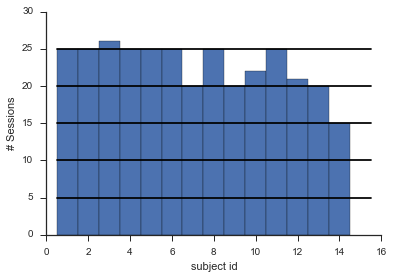

In [22]:
for s, sub in data.groupby('snum'):
    bar(s-0.5, len(unique(sub.session)), 1)
plot([0.5, 15.5], [25, 25], 'k')
plot([0.5, 15.5], [5, 5], 'k')
plot([0.5, 15.5], [10, 10], 'k')
plot([0.5, 15.5], [15, 15], 'k')
plot([0.5, 15.5], [20, 20], 'k')
sns.despine()
xlabel('subject id')
ylabel('# Sessions')

In [23]:
sub = data[data.snum==3]
unique(sub.session)

array([u'20151207T162158', u'20151207T163612', u'20151207T164706',
       u'20151207T165719', u'20151207T170753', u'20151207T171828',
       u'20151208T150434', u'20151208T151459', u'20151208T152542',
       u'20151208T154258', u'20151208T155344', u'20151215T162538',
       u'20151215T163737', u'20151215T164904', u'20151215T170731',
       u'20151215T172040', u'20151216T143922', u'20151216T145101',
       u'20151216T150219', u'20151216T152100', u'20151216T153125',
       u'20151217T123517', u'20151217T124642', u'20151217T125752',
       u'20151217T131409', u'20151217T132413'], dtype=object)

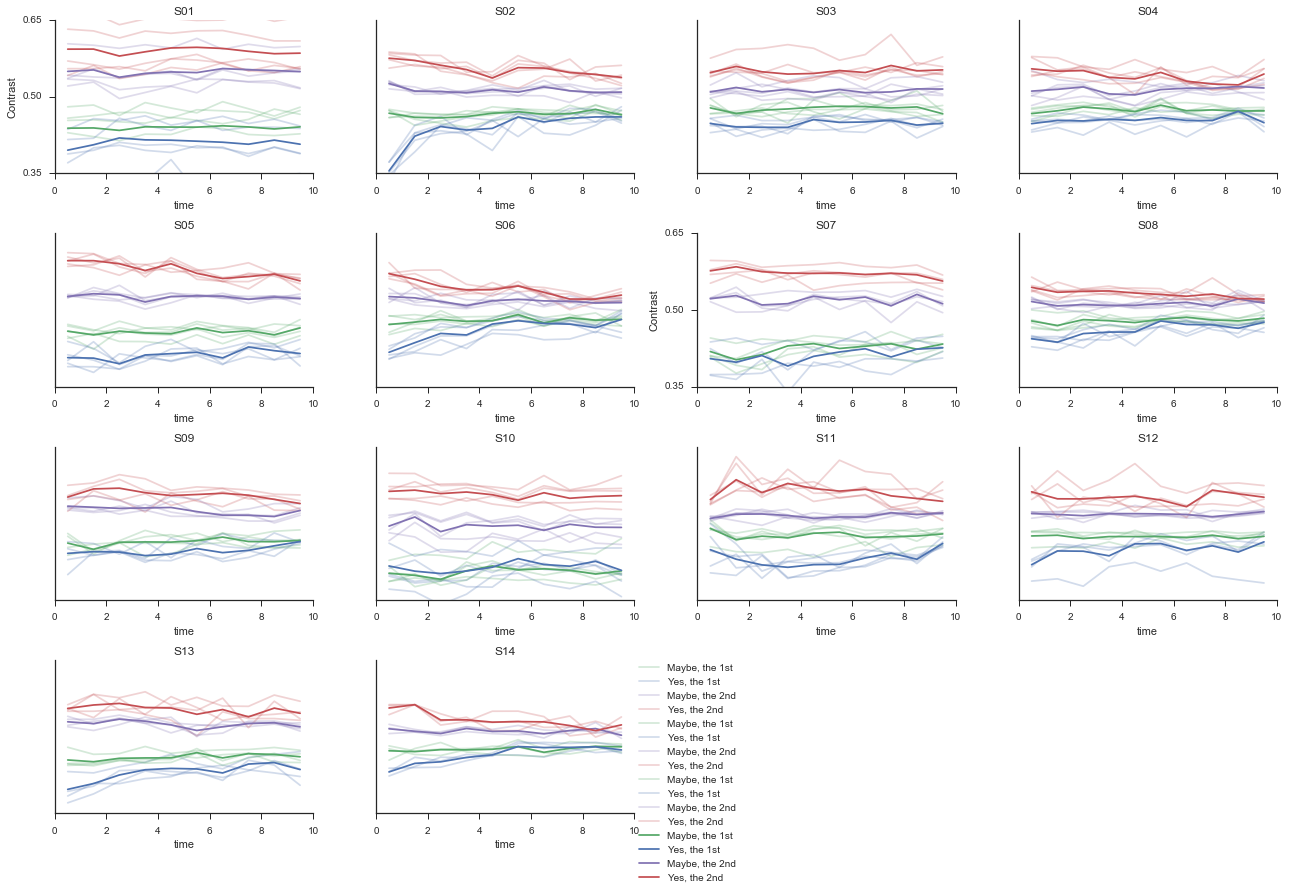

In [24]:
figure(figsize=(18, 12))
for c, sub in data.groupby('snum'):
    subplot(4,4,c)
    for d, day in sub.groupby('day'):
        behavior.conf_kernels(day, alpha=0.25)
    behavior.conf_kernels(sub)
    if c == 1 or c==7:
        ylabel('Contrast')
    else:
        yticks([])
    title('S%02i'%c)
legend(bbox_to_anchor=(1.001, 1), loc=2, borderaxespad=0.)
tight_layout()
savefig('/Users/nwilming/u/conf_analysis/plots/kernels.pdf')

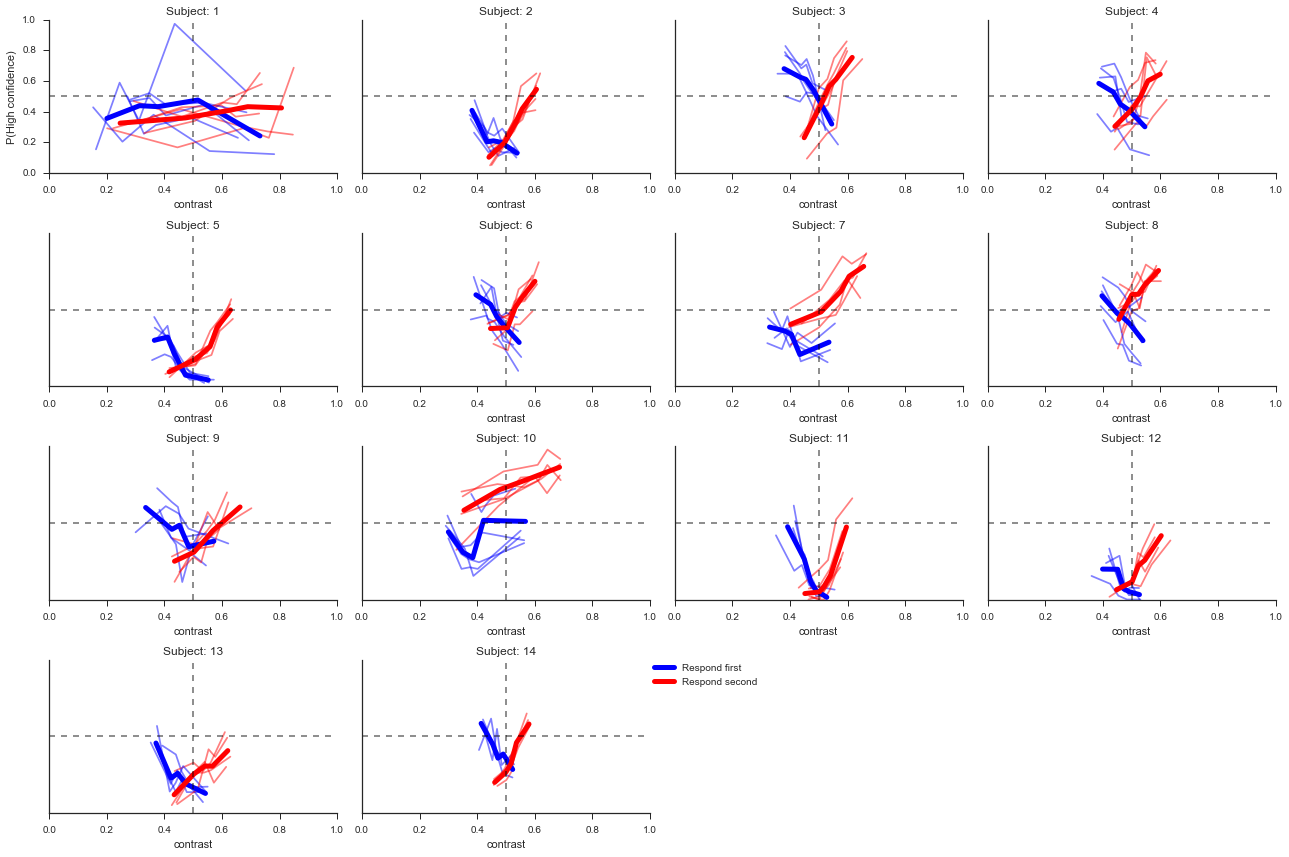

In [25]:
figure(figsize=(18, 12))
for c, sub in data.groupby('snum'):
    subplot(4,4,c)
    cnt = 0
    for block, s in sub.groupby('day'):
        frac, centers, ft = behavior.contrast_vs_accuracy(s[s.response==-1], 2, conf_sample=slice(0,10))
        plot(centers, frac, 'b-', alpha=0.5)
        frac, centers, ft = behavior.contrast_vs_accuracy(s[s.response==1], 2, conf_sample=slice(0,10))
        plot(centers, frac, 'r-', alpha=0.5)
        cnt += 1
    frac, centers, ft = behavior.contrast_vs_accuracy(sub[sub.response==-1], 2, conf_sample=slice(0,10))
    plot(centers, frac, 'b-', alpha=1, lw=5, label='Respond first')
    frac, centers, ft = behavior.contrast_vs_accuracy(sub[sub.response==1], 2, conf_sample=slice(0,10))
    plot(centers, frac, 'r-', alpha=1, lw=5, label='Respond second')
    sns.despine()
    ylim([0, 1])
    xlim([0, 1])
    if c>1:
        yticks([])
    xlabel('contrast')
    if c==1:
        ylabel('P(High confidence)')
    plot(xlim(), [0.5, 0.5], 'k--', alpha=0.5)  
    plot([0.5, 0.5],ylim(), 'k--', alpha=0.5)  
    title('Subject: %i'%c)
legend(bbox_to_anchor=(1.001, 1), loc=2, borderaxespad=0.)
tight_layout()
savefig('/Users/nwilming/u/conf_analysis/plots/confidence_vs_contrast.pdf')

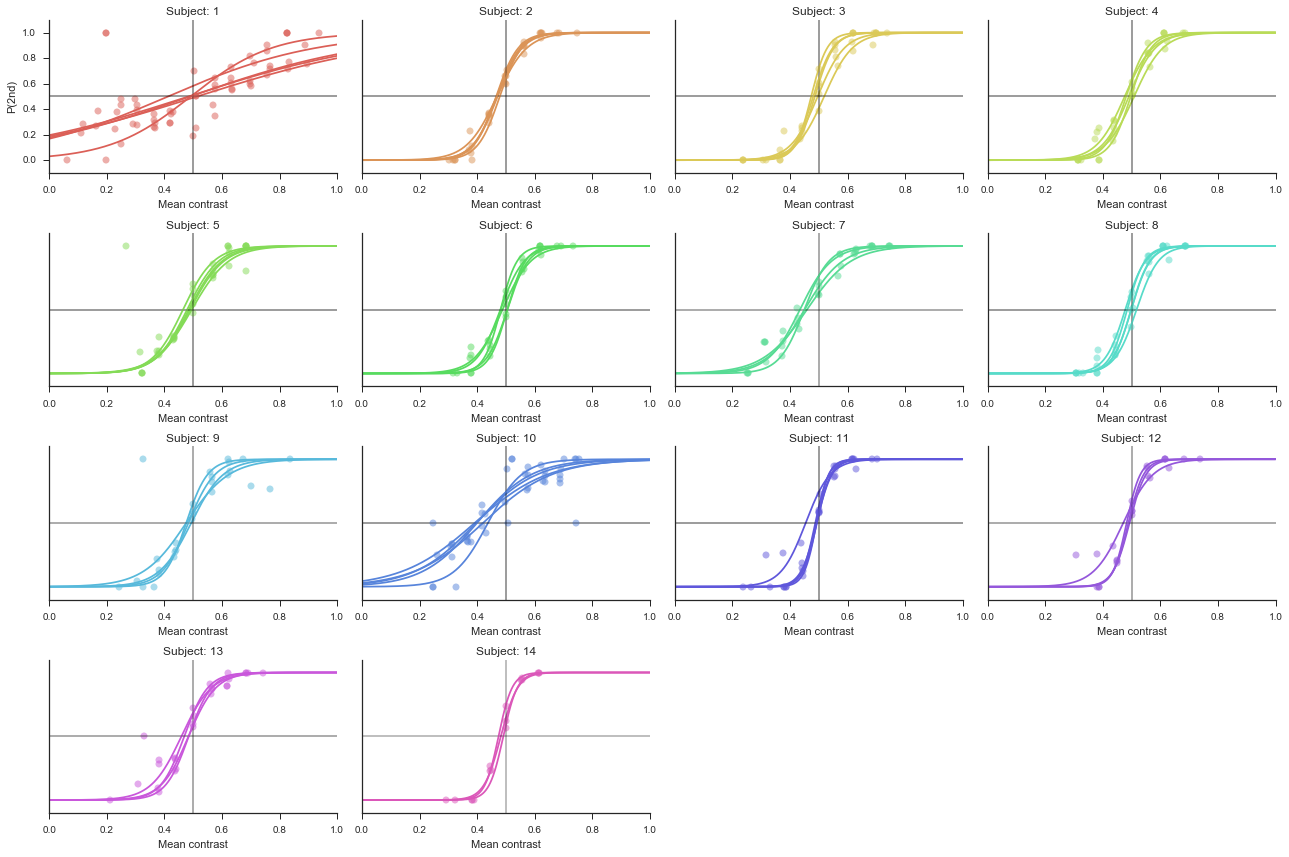

In [26]:
import patsy
import pandas as pd
figure(figsize=(18,12))
x = linspace(0, 1, 1000)
colors = sns.color_palette("hls", 15)
for (snum, day), sub in data.groupby(['snum', 'day']):
    subplot(4,4, snum)
    log_res, results = behavior.fit_logistic(sub, 'R ~ mc + 1', summary=False)
    X = vstack([ones(x.shape), x])
    plot(x, results.predict(X.T), label='Sub: %i'%snum, color=colors[snum-1])

    for c, d in sub.groupby(pd.cut(sub.mc, linspace(0, 1, 16))):
        if len(d) == 0:
            continue
        plot(d.mc.mean(), d.R.sum()/float(len(d)), 'o', color=colors[snum-1], alpha=0.5)
    ylim([-0.1, 1.1])
    sns.despine()
    ylabel('P(2nd)')
    xlabel('Mean contrast')
    #legend(bbox_to_anchor=(1.001, 1), loc=2, borderaxespad=0.)
    plot(xlim(), [0.5, 0.5], 'k', alpha=0.1)
    plot([.5, .5], ylim(), 'k', alpha=0.1)
    if snum>1:
        ylabel('')
        yticks([])
    title('Subject: %i'%snum)
tight_layout()
savefig('/Users/nwilming/u/conf_analysis/plots/response_curves.pdf')

10
Average rection time difference Low-High: -93.0
P(13 | binom(n=14, p=0.5)): 6.103515625e-05


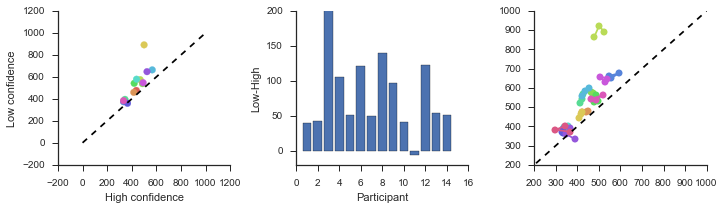

In [27]:
figure(figsize=(10,3))
cnt = 0
colors = sns.color_palette("hls", 15)
sub_means = []
for (c, sub) in data.groupby('snum'):
    c1 = sub[sub.confidence==1]
    c2 = sub[sub.confidence==2]
    
    sub_means.append((1000*c1.choice_rt.mean(), 1000*c2.choice_rt.mean()))
sub_means = array(sub_means)
subplot(1,3,1)
print argmax(sub_means[:,1]-sub_means[:,0])
scatter(sub_means[:,1],sub_means[:,0], 45, color=colors)
ylabel('Low confidence')
xlabel('High confidence')
plot([0, 1000], [0,1000], 'k--')
subplot(1,3,2)
bar(arange(1,sub_means.shape[0]+1)-0.4, sub_means[:,0]-sub_means[:,1], 0.8)
ylabel('Low-High')
xlabel('Participant')
ylim([-20, 200])
print 'Average rection time difference Low-High: %3.1f'% round(diff(sub_means.mean(0))[0],1)

sns.despine()
tight_layout()
from scipy.stats import binom
cnt = sum(sub_means[:,0] > sub_means[:,1])
print 'P(%i | binom(n=14, p=0.5)):'%cnt, 1-binom.cdf(cnt, 14, 0.5 )

cnt = 0
colors = sns.color_palette("hls", 15)
subplot(1,3,3)
for (c, sub) in data.groupby('snum'):
    sub_means = []    
    for v, var in sub.groupby('noise_sigma'):
        c1 = var[var.confidence==1]
        c2 = var[var.confidence==2]
        sub_means.append((1000*c1.choice_rt.mean(), 1000*c2.choice_rt.mean()))
    sub_means = array(sub_means)
    plot(sub_means[:,1],sub_means[:,0], 'o-', color=colors[c])
plot([0, 1000], [0,1000], 'k--')
ylim([200, 1000])
xlim([200, 1000])
sns.despine()

2.0


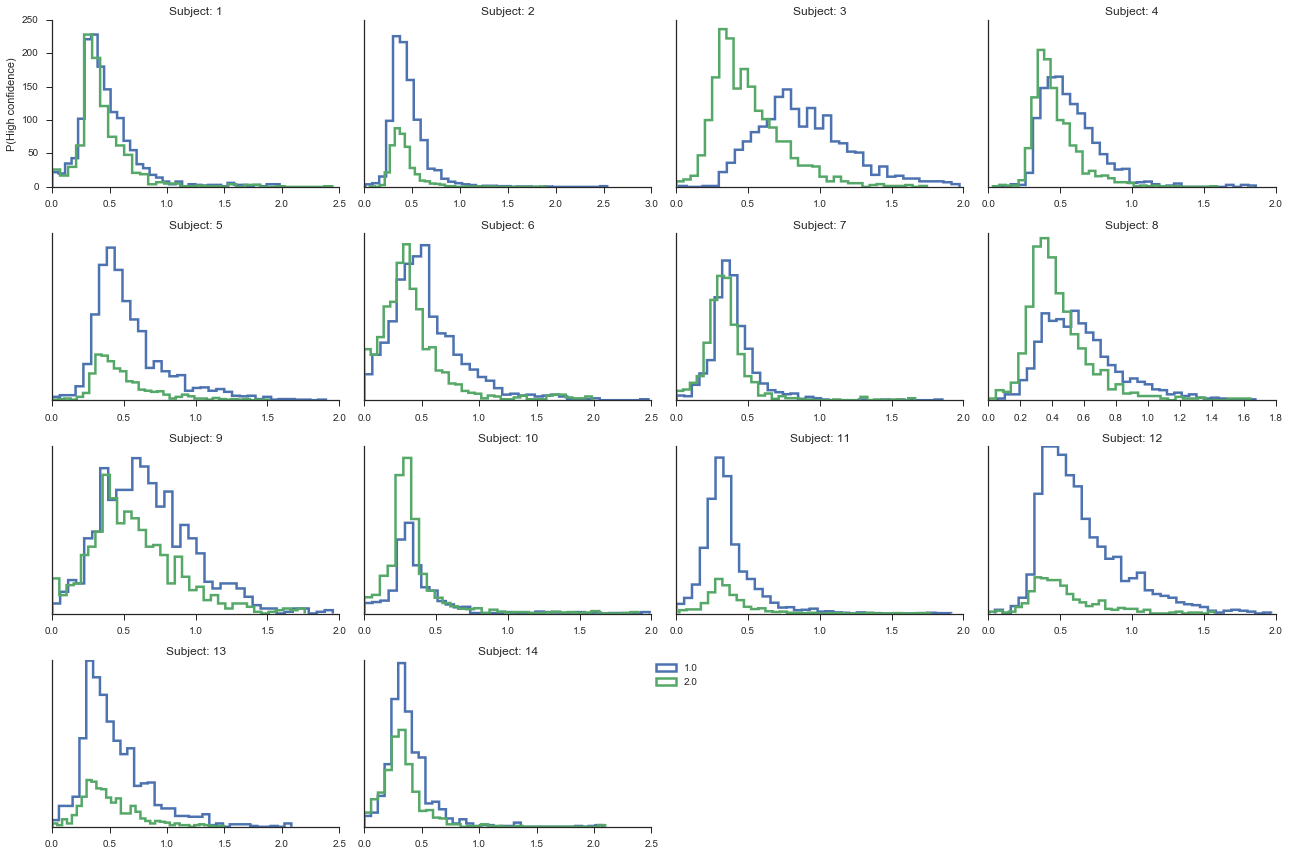

In [28]:
figure(figsize=(18, 12))
for c, sub in data.groupby('snum'):
    subplot(4,4,c)
    cnt = 0
    for d, dec in sub.groupby(['confidence']):
        rts = dec.choice_rt[~isnan(dec.choice_rt)]
    
        hist(rts.values, 35, histtype='step', label=str(d), lw=2.5)
    if c>1:
        yticks([])
    if c==1:
        ylabel('P(High confidence)')

    title('Subject: %i'%c)
sns.despine()
legend(bbox_to_anchor=(1.001, 1), loc=2, borderaxespad=0.)
tight_layout()
print d

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      R   No. Observations:                31544
Model:                            GLM   Df Residuals:                    31541
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -17762.
Date:                Do, 03 Mär 2016   Deviance:                       35524.
Time:                        12:09:22   Pearson chi2:                 4.30e+04
No. Iterations:                     7                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -7.1222      0.104    -68.681      0.000        -7.325    -6.919
mc            13.8485      0.196     70.553      0.00

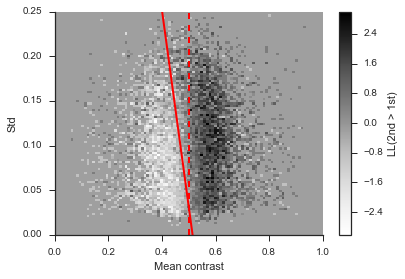

In [29]:
log_res, results = behavior.fit_logistic(data, 'R ~ mc + stdc')
_=behavior.plot_model(data, results, bins=[linspace(0,.25,100), linspace(0,1,100)])
sns.despine()
xlabel('Mean contrast')
ylabel('Std')
colorbar(label='LL(2nd > 1st)')
savefig('/Users/nwilming/u/conf_analysis/plots/contrast_vs_std.pdf')

In [30]:
log_res, results = behavior.fit_logistic(data, '''
R ~ C(snum) + (mc  + stdc + mc*stdc + C(confidence) + C(side) + C(expand))
''')

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      R   No. Observations:                31544
Model:                            GLM   Df Residuals:                    31524
Model Family:                Binomial   Df Model:                           19
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -17022.
Date:                Do, 03 Mär 2016   Deviance:                       34045.
Time:                        12:09:26   Pearson chi2:                 3.27e+04
No. Iterations:                     7                                         
                           coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
Intercept               -5.2339      0.247    -21.210      0.000        -5.718    -4.750
C(snum)[T.2]           

In [14]:
20*60/30

40